In [45]:
import numpy as np
import random
from typing import Literal, Optional

In [46]:
{'right':0,'up':90,'left':180,'down':270}

{'right': 0, 'up': 90, 'left': 180, 'down': 270}

In [47]:
class Rotator:
    def __init__(self, degree_to_rotate: Literal[0, 90, 180, 270]):
        # self.matrix = matrix
        self.degree_to_rotate = degree_to_rotate

    def __enter__(self):
        pass

    def rotate(self, matrix: np.ndarray)-> np.ndarray:
        return np.rot90(matrix, k=int(self.degree_to_rotate/90), axes=(1,0))
        
    @staticmethod
    def _rotate( matrix: np.ndarray, degree_to_rotate: Literal[0, 90, 180, 270]):
        return np.rot90(matrix, k=int(degree_to_rotate/90), axes=(1,0))

        
    def unrotate(self, matrix: np.ndarray)-> np.ndarray:
        return np.rot90(matrix, k=int(self.degree_to_rotate/90), axes=(0,1))
    
    @staticmethod
    def _unrotate( matrix: np.ndarray, degree_to_rotate: Literal[0, 90, 180, 270]):
        return np.rot90(matrix, k=int(degree_to_rotate/90), axes=(0,1))


    # @property
    # def rotated(self):
    #     return self.rotate(self.matrix)
    
    # @property
    # def unrotated(self):
    #     return self.unrotate(self.rotated)
    
    def rot(self, deg: Literal[0, 90, 180, 270]):
        self.degree_to_rotate = deg
        return self
        
        
        




In [139]:
class Board:
    def __init__(self, n: int=4):
        self.actions = {0:('right', 0),1:('up',90),2:('left',180),3:('down',270)}
        self.length = n
        self.board = self.create_board(n)
        self.rotator = Rotator(0)

    def create_board(self, length):
        return np.zeros((length, length), dtype=np.int32)

    def reset(self):
        """ Born a board that either has two 2 or a 2 and 4. """
        self.clear()
        self.random_born()
        self.random_born(2 if np.random.random() < 0.5 else 4)

    def clear(self):
        self.board = self.create_board(self.length)

    @staticmethod
    def _push(vector: np.ndarray):
        """ Put all elements to the right side (0deg). """
        v = np.zeros_like(vector)
        non_zero = vector[vector != 0]
        if len(non_zero) == 0:
            return vector
        v[-len(non_zero):] = non_zero
        vector = v
        return vector

    @staticmethod
    def _join_reverse(vector: np.ndarray):
        """ Join the neighboring elements from left to right, e.g. (2,0,0,2)->(0,0,0,4) """
        previous = None
        previous_index = -1
        for i, current in enumerate(vector):
            if current == previous:
                vector[previous_index], vector[i] = 0, previous+current
                previous = None
                previous_index = -1

                continue
            if current != 0:
                previous = vector[i]  # Not current as we mutated the vector.
                previous_index = i
        return vector

    @staticmethod
    def _join(vector: np.ndarray):
        return Board._join_reverse(vector[::-1])[::-1]

    @staticmethod
    def _squeezable_right(vector: np.ndarray):
        """ If the row vector is filled by all different elements, it is not squeezable. """
        if np.array_equal(Board._squeeze_right(vector), vector): return False
        return True

    @staticmethod
    def _squeezable(direction: Literal[0, 90, 180, 270], board: np.ndarray):
        board = Rotator._rotate(board, direction)
        for i, row in enumerate(board):
            if Board._squeezable_right(row): return True
        return False 

    def squeezable(self, direction: Literal[0, 90, 180, 270]):
        return self._squeezable(direction, self.board)


    @staticmethod
    def _squeeze_right(vector: np.ndarray):
        """ Squeeze all elements from left to right (0deg). """
        return Board._push(Board._join(vector))

    @staticmethod
    def _squeeze(direction: Literal[0, 90, 180, 270], board: np.ndarray):
        board = Rotator._rotate(board, direction)
        for i, row in enumerate(board):
            board[i, :] = Board._squeeze_right(row)
        return Rotator._unrotate(board, direction)

    def squeeze(self, direction: Literal[0, 90, 180, 270]):
        self.board = self._squeeze(direction, self.board)

    def _available_index(self, board: np.ndarray):
        return [i for i, x in np.ndenumerate(board) if int(x) == 0]

    @staticmethod
    def available_actions(board: np.ndarray):
        return [int(Board._squeezable(direction, board)) for direction in [0,90,180,270]]

    def _step(self, action: int, board: np.ndarray):
        direction = self.choice_to_direction(action)
        
        next_board = self._squeeze(direction, board)
        next_board = self._random_born(next_board)
        reward = Board.evaluate_reward(board, next_board)
        done = self._is_done(next_board)
        return board, reward, done


    def step(self, action: int):
        cache_board = self.board.copy()
        direction = self.choice_to_direction(action)
        self.squeeze(direction)
        self.random_born()
        reward = Board.evaluate_reward(cache_board, self.board)
        done = self.is_done()
        return self.board, reward, done


    def _random_born(self, board: np.ndarray, num: int = 2):
        try:
            random_index = random.choice(self._available_index(board))
        except IndexError:
            raise IndexError('The board is full.')
        b = board.copy()
        b[random_index] = num
        return b

    def random_born(self, num: int = 2):
        self.board = self._random_born(self.board, num)
    
    def _is_done(self,board:np.ndarray):
        if 0 in board: return False
        for deg in [0,90,180,270]:
            if self._squeezable(deg, board):
                return False
        return True

    def is_done(self):
        return self._is_done(self.board)

    
    
    def choice_to_direction(self,choice: int)->Literal[0, 90, 180, 270]:
        return self.actions[choice][1]
    
    @staticmethod
    def evaluate_reward(previous_board:np.ndarray, current_board:np.ndarray):
        def nth_max(sorted: np.ndarray, n:int=1)->int:
            try:
                return sorted[-n]
            except IndexError:
                return sorted[-1]
        # previous_sorted = np.sort(np.unique(previous_board).flatten())
        current_sorted = np.sort(np.unique(current_board).flatten())
        num_nth_max = lambda board,sorted, n:len(board[board==nth_max(sorted, n)])
        """ IF the num of nth maximum in current_board is greater than that of previous_board, it is doing great"""
        if np.max(current_board) > np.max(previous_board):
            return 5
        if num_nth_max(current_board,current_sorted, 1) > num_nth_max(previous_board,current_sorted, 1):
            return 4
        if num_nth_max(current_board,current_sorted, 2) > num_nth_max(previous_board,current_sorted, 2):
            return 3
        if num_nth_max(current_board,current_sorted, 3) > num_nth_max(previous_board,current_sorted, 3):
            return 2
        if num_nth_max(current_board,current_sorted, 4) > num_nth_max(previous_board,current_sorted, 4):
            return 1
        if np.array_equal(current_board, previous_board):
            return -5 #invalid
        return 0
    
    @staticmethod
    def nth_max(sorted: np.ndarray, n:int=1)->int:
        try:
            return sorted[-n]
        except IndexError:
            return sorted[-1]

    




In [49]:
zero_to_31 = [[np.floor((x/2**3)%2),np.floor((x/2**2)%2),np.floor((x/2)%2),x%2] for x in range(2**5)]

In [50]:
Board._squeeze_right(np.array([2,2,4,4],dtype=np.int32))

array([0, 0, 4, 8])

In [51]:
Board._join_reverse(np.array([2,0,0,2]))

array([0, 0, 0, 4])

In [52]:
b = Board()

In [135]:
b.board = np.array([[4,8,2,4],[8,256,4,64],[2,64,32,4],[8,32,8,2]])
b.is_done()


True

In [136]:
Board.available_actions(b.board)

[0, 0, 0, 0]

In [132]:
np.sort(np.unique(b.board).flatten())

array([0, 2, 4])

In [130]:
b.reset()
b.board

array([[0, 0, 0, 0],
       [4, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 2]])

## Baseline

Lets take 10000 samples of random actions for the baseline.  
The action is random but valid.  
Records how many it can make til the game is ended.

In [143]:
from numba import jit

@jit()
def sample(n:int=10000, valid=True):
    round_counts:list[int] = []
    rewards: list[int] = []
    for epoch in range(n):
        b.reset()
        done = False
        count = 0
        while not done:
            action = random.choice([0,1,2,3])
            if valid:
                while not b.squeezable(b.choice_to_direction(action)):
                    action = random.choice([0,1,2,3])

            board, reward, done = b.step(action)
            rewards.append(reward)
            count += 1
        round_counts.append(count)
    return round_counts, rewards
    

In [57]:
round_counts, rewards = sample()

C:\Users\user\AppData\Local\Temp\ipykernel_8036\4122169050.py:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "bootstrap" failed type inference due to: Untyped global name 'b': Cannot determine Numba type of <class '__main__.Board'>

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_8036\4122169050.py", line 8:
<source missing, REPL/exec in use?>

  @jit()
C:\Users\user\AppData\Local\Temp\ipykernel_8036\4122169050.py:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "bootstrap" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_8036\4122169050.py", line 7:
<source missing, REPL/exec in use?>

  @jit()
c:\ProgramData\Anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "bootstrap" was compiled in object mode without forceobj=True, but has l

In [58]:
b.board

array([[ 2,  4,  8,  4],
       [ 4,  8, 16,  8],
       [16, 64, 32,  2],
       [ 2, 16,  2, 16]])

(array([ 356., 2227., 3477., 1944., 1234.,  582.,  130.,   27.,   18.,
           5.]),
 array([ 41. ,  81.7, 122.4, 163.1, 203.8, 244.5, 285.2, 325.9, 366.6,
        407.3, 448. ]),
 <BarContainer object of 10 artists>)

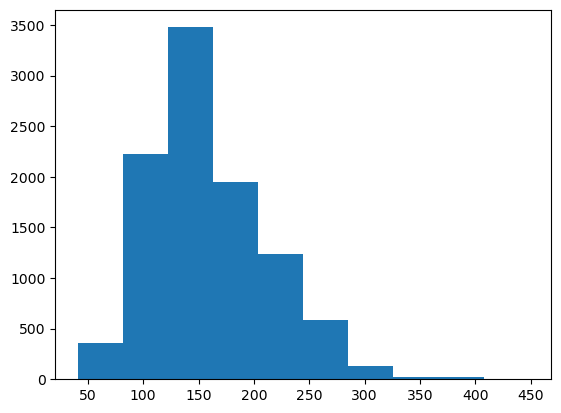

In [59]:
import matplotlib.pyplot as plt
plt.hist(round_counts)

Surprisingly, the sample is not normal distributed.    
it is in fact right tailed.  
we may use the median for baseline.

In [60]:
np.percentile(round_counts,50), np.mean(round_counts)

(153.0, 159.3142)

## Reward span


In [140]:
_ ,rewards = sample(1000)

(array([85547.,     0., 28396.,     0., 21049.,     0., 15306.,     0.,
         4340.,  3456.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

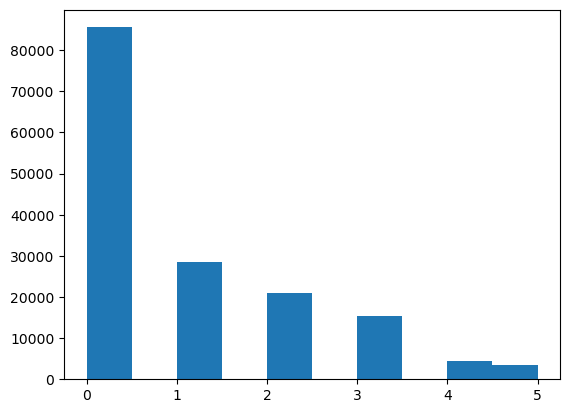

In [141]:
plt.hist(rewards)


C:\Users\user\AppData\Local\Temp\ipykernel_8036\1198751277.py:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "sample" failed type inference due to: Untyped global name 'b': Cannot determine Numba type of <class '__main__.Board'>

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_8036\1198751277.py", line 8:
<source missing, REPL/exec in use?>

  @jit()
C:\Users\user\AppData\Local\Temp\ipykernel_8036\1198751277.py:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "sample" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_8036\1198751277.py", line 7:
<source missing, REPL/exec in use?>

  @jit()
c:\ProgramData\Anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "sample" was compiled in object mode without forceobj=True, but has lifted loo

(array([45254.,     0., 27214.,     0., 23309.,     0., 18695.,     0.,
         6751.,  4971.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

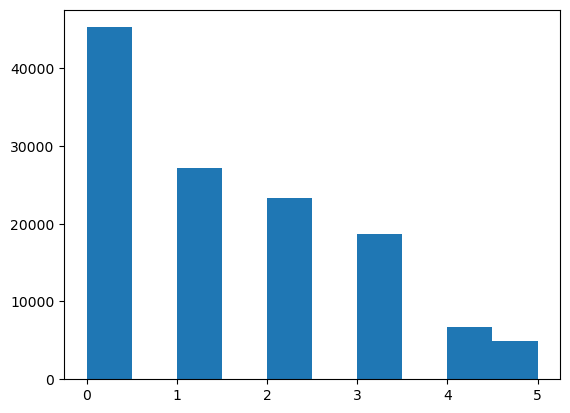

In [144]:
_ ,rewards = sample(1000, valid=False)
plt.hist(rewards)



In [145]:
rewards[rewards==-5]

3